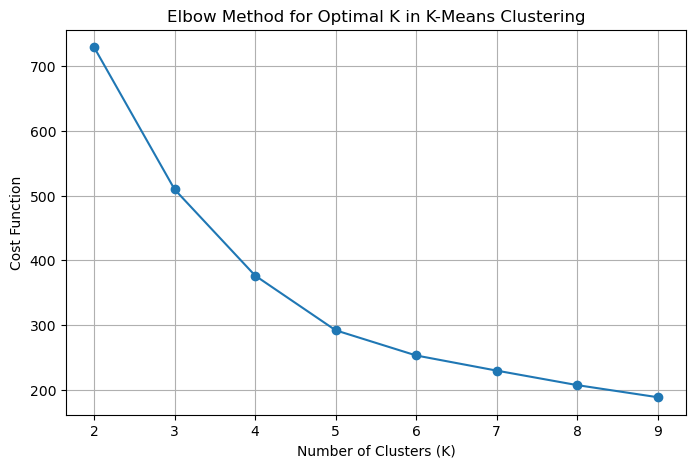

Silhouette Score: 0.3513


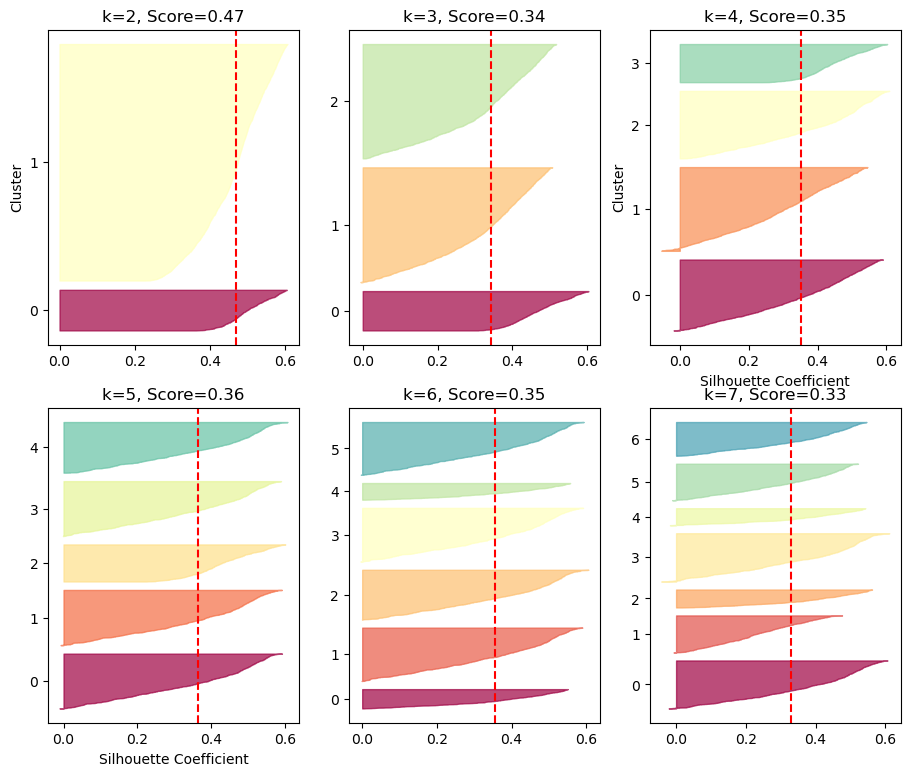

In [7]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist
from matplotlib.ticker import FixedLocator, FixedFormatter

# Load dataset
df = pd.read_csv("shopping_behavior_updated.csv").drop(columns=['Customer ID'])
frequency_map = {'Fortnightly': 14, 'Weekly': 7, 'Annually':365, 'Quarterly':120, 'Bi-Weekly':14,
       'Monthly':30, 'Every 3 Months': 90}
df['Frequency of Purchases_Num'] = df['Frequency of Purchases'].map(frequency_map)
features = ['Purchase Amount (USD)','Previous Purchases','Frequency of Purchases_Num']

df = df[features]

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Encode categorical variables and scale numerical ones
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
scalers = {col: MinMaxScaler().fit(df[[col]]) for col in numerical_cols}

df_encoded = df.copy()
for col, encoder in label_encoders.items():
    df_encoded[col] = encoder.transform(df[col])
for col, scaler in scalers.items():
    df_encoded[col] = scaler.transform(df[[col]])

df_np = df_encoded.to_numpy()
categorical_indices = [df.columns.get_loc(col) for col in categorical_cols]

# Determine optimal K using Elbow Method
costs = []
K_range = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, n_init=1000, verbose=0)
    km.fit_predict(df_np)
    costs.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, costs, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost Function")
plt.title("Elbow Method for Optimal K in K-Means Clustering")
plt.grid(True)
plt.show()

# Apply K-Prototypes clustering with optimal K (assuming 4 based on plot)
optimal_k = 4
kmean = KMeans(n_clusters=optimal_k, n_init=5, verbose=0)
df_encoded["prod_cluster"] = kmean.fit_predict(df_np)

# Decode categorical values back to original labels
def decode_cluster(row):
    for col in categorical_cols:
        row[col] = label_encoders[col].inverse_transform([int(row[col])])[0]
    return row

df_decoded = df_encoded.copy()
df_decoded[numerical_cols] = df[numerical_cols]  # Restore original scaled values
cluster_composition = df_decoded.groupby("prod_cluster").apply(lambda x: x.mode().iloc[0]).apply(decode_cluster, axis=1)

silhouette_avg = silhouette_score(df_np,df_encoded["prod_cluster"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Silhouette Analysis
plt.figure(figsize=(11, 9))
for k in (2, 3, 4, 5, 6, 7):
    plt.subplot(2, 3, k - 1)
    y_pred = KMeans(n_clusters=k, n_init=5, verbose=0).fit_predict(df_np)
    silhouette_coeffs = silhouette_samples(df_np, y_pred)
    padding = len(df_np) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coeffs[y_pred == i]
        coeffs.sort()
        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    if k in (4, 5):
        plt.xlabel("Silhouette Coefficient")
    plt.axvline(x=np.mean(silhouette_coeffs), color="red", linestyle="--")
    plt.title(f"k={k}, Score={np.mean(silhouette_coeffs):.2f}")
plt.show()


In [8]:
df['Purchase Amount (USD)']

0       53
1       64
2       73
3       90
4       49
        ..
3895    28
3896    49
3897    33
3898    77
3899    81
Name: Purchase Amount (USD), Length: 3900, dtype: int64

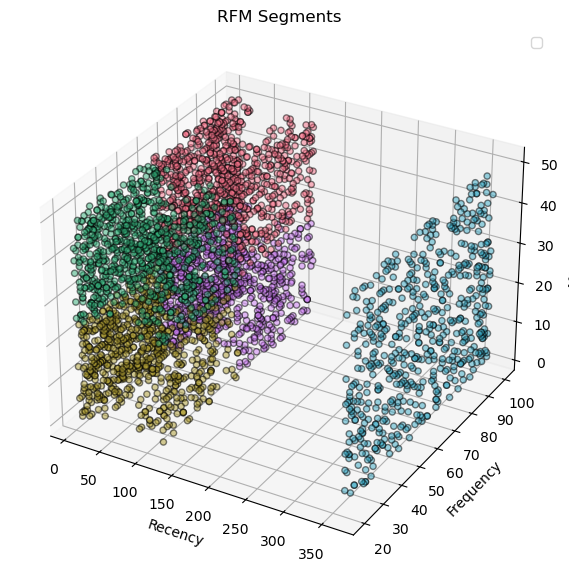

In [9]:
import seaborn as sns

# Apply KMeans clustering
num_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=100)
df_encoded['Cluster'] = kmeans.fit_predict(df_np)

# 3D Visualization
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

# Use Seaborn color palette
palette = sns.color_palette("husl", num_clusters)

# Define cluster colors
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for cluster in range(num_clusters):
    subset = df_decoded[df_encoded['Cluster'] == cluster]
    ax.scatter(subset['Frequency of Purchases_Num'], subset['Purchase Amount (USD)'], \
               subset['Previous Purchases'], c=[palette[cluster]], alpha=0.5, edgecolors='k')

# Labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('RFM Segments')

plt.legend()
plt.show()